In [1]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from PIL import Image
import matplotlib.pyplot as plt

# Initialize MTCNN for face detection
mtcnn = MTCNN(keep_all=True)

# Load pre-trained FaceNet model
resnet = InceptionResnetV1(pretrained='casia-webface').eval()

# Load an image containing faces
img = Image.open('fake.007545.jpg')

# Detect faces in the image
boxes, _ = mtcnn.detect(img)

In [2]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from facenet_pytorch import MTCNN
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
import matplotlib.pyplot as plt
import numpy as np
import random



class DeepfakeFaceDataset(Dataset):
    def __init__(self, root_dir, transform=None, resize=256):
        """
        root_dir : Directorio con todas las imágenes, organizadas en subdirectorios 'real' y 'fake'
        "resize" : las detecciones no tendran mismo tamaño....

        """
        self.root_dir = root_dir
        self.transform = transform
        self.resize = resize
        self.mtcnn = MTCNN(keep_all=True)
        self.data = []
        self.labels = []

        # Cargar los datos
        for label, cls in enumerate(['real', 'fake']):
            cls_folder = os.path.join(root_dir, cls)
            for img_name in os.listdir(cls_folder):
                img_path = os.path.join(cls_folder, img_name)
                self.load_image_faces(img_path, label)

    def load_image_faces(self, img_path, label):
        img = Image.open(img_path)
        boxes, _ = self.mtcnn.detect(img)
        if boxes is not None:
            for box in boxes:  # Procesar todas las caras detectadas
                face = img.crop(box).resize((self.resize, self.resize))
                self.data.append(face)
                self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        face = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            face = self.transform(face)

        return face, label


# Ejemplo de uso
transform = transforms.Compose([
    transforms.ToTensor(),  # Convierte los parches PIL a tensores de PyTorch
    transforms.RandomHorizontalFlip(),  # Aplica un giro horizontal aleatorio
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.1), ratio=(0.3, 3.3), value=0, inplace=False),
    #transforms.RandomRotation(degrees=10),  # Rota la imagen ±20 grados aleatoriamente

    # Añade aquí cualquier otra transformación que necesites
])
dataset = DeepfakeFaceDataset(root_dir='C:/Users/X571/Documents/VIT/Task_1/development', transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)



def set_seed(seed=42):

    random.seed(seed)  
    np.random.seed(seed) 
    torch.manual_seed(seed)  
    torch.cuda.manual_seed(seed)  
    torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.deterministic = True  
    torch.backends.cudnn.benchmark = False  

set_seed(42)  


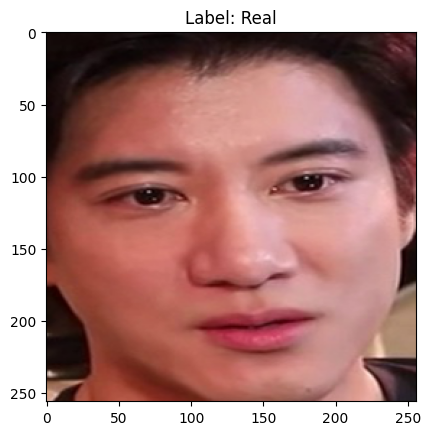

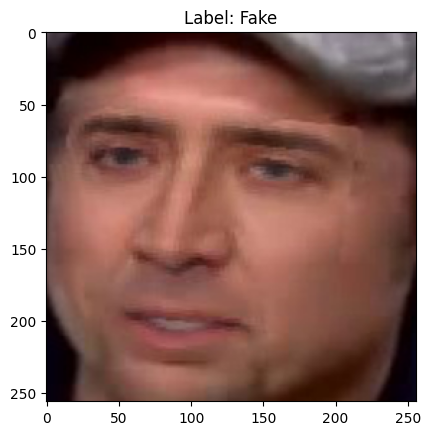

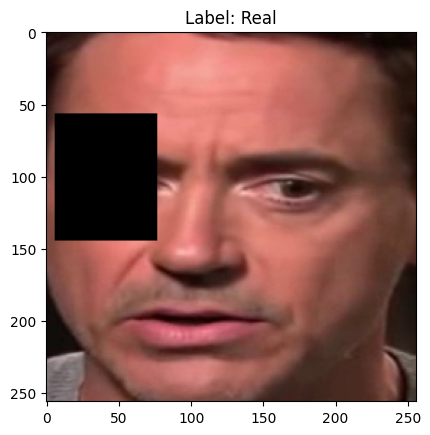

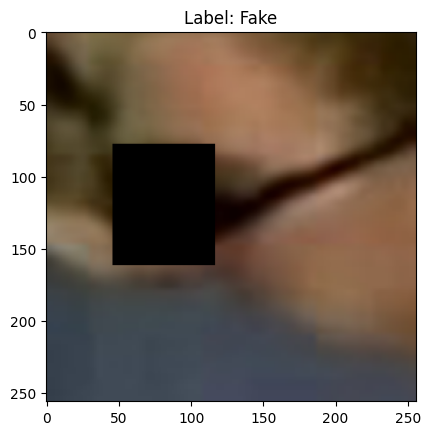

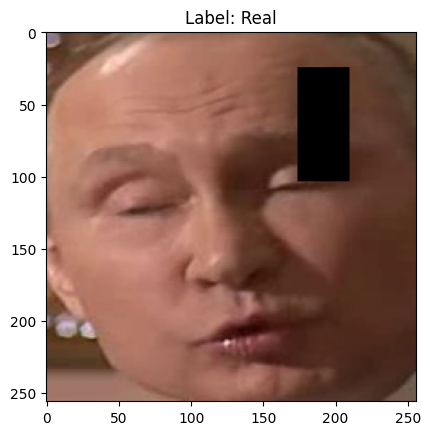

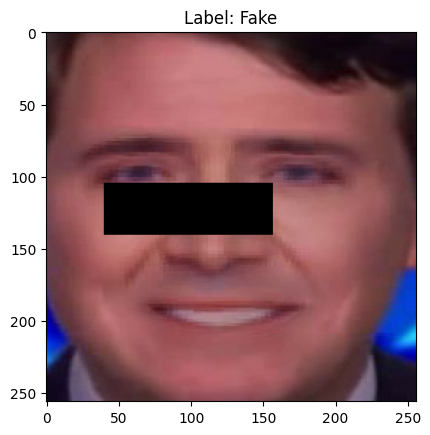

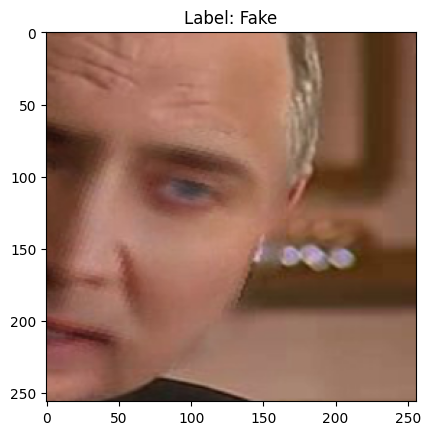

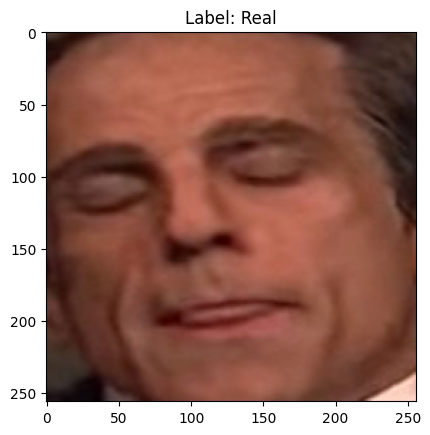

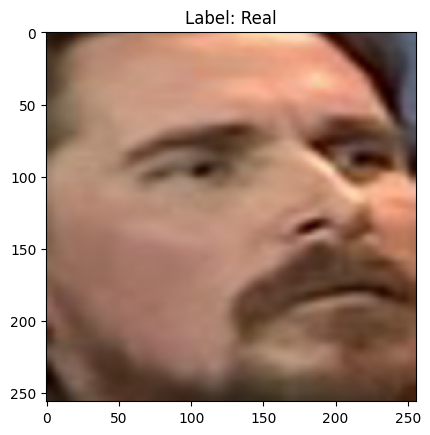

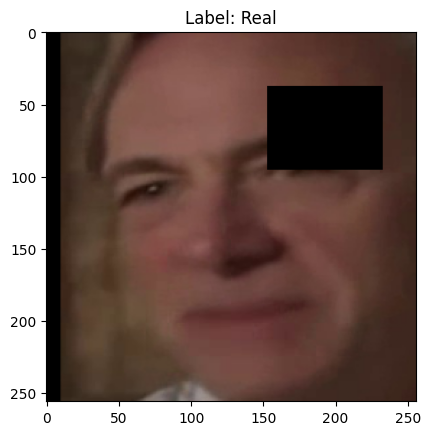

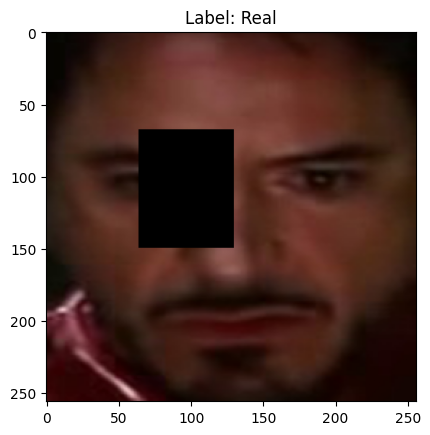

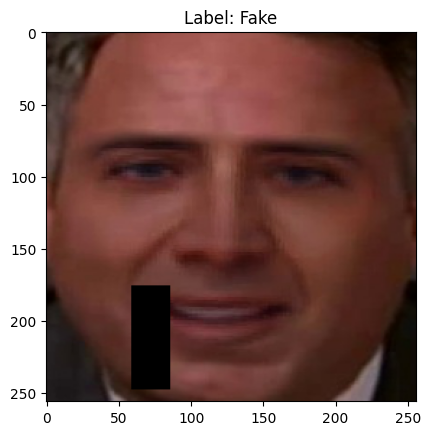

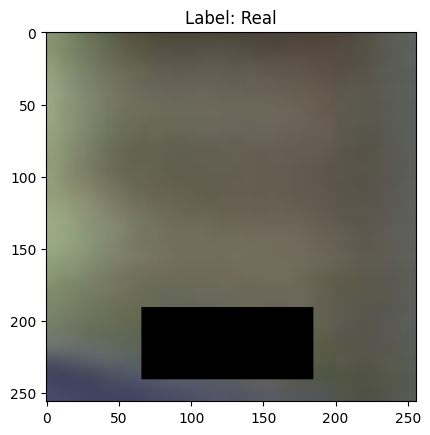

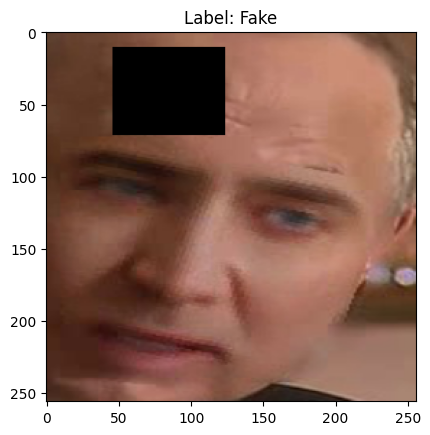

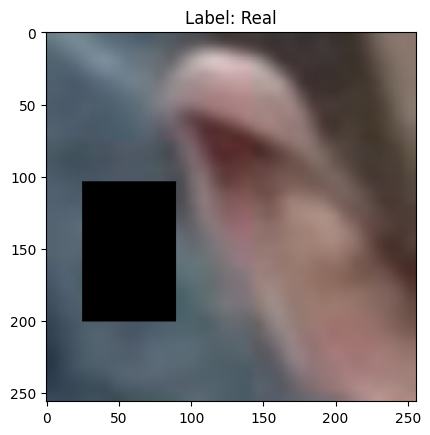

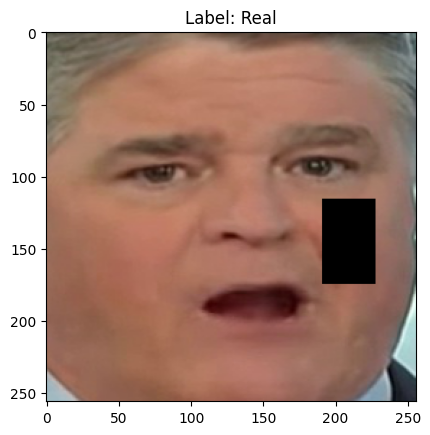

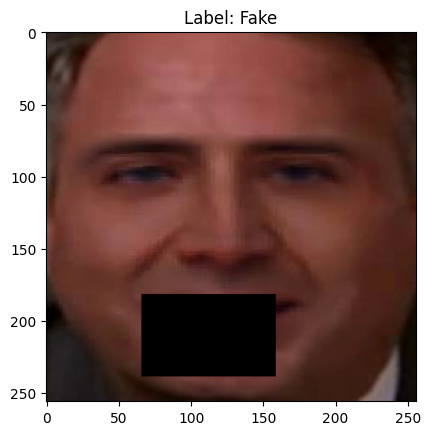

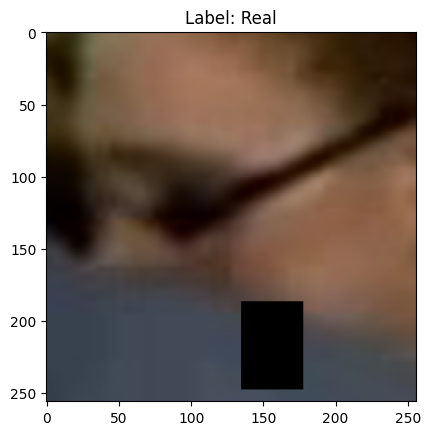

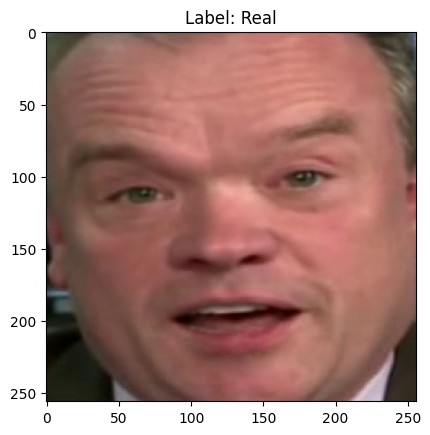

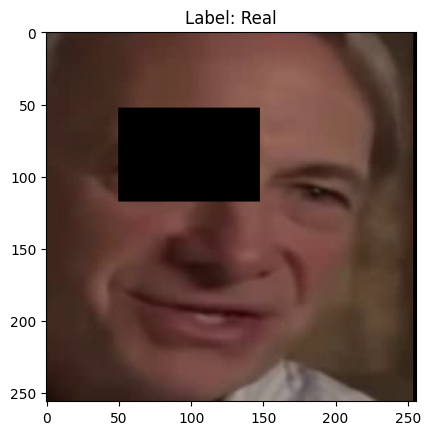

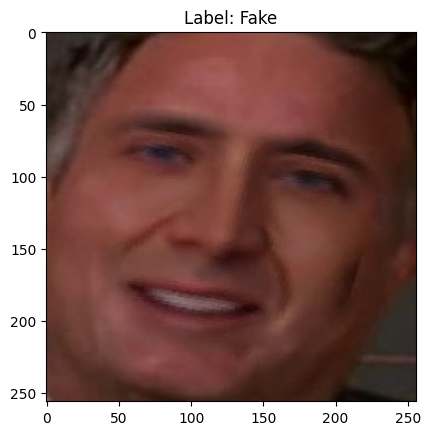

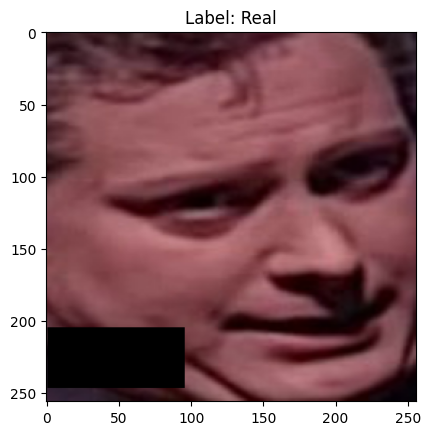

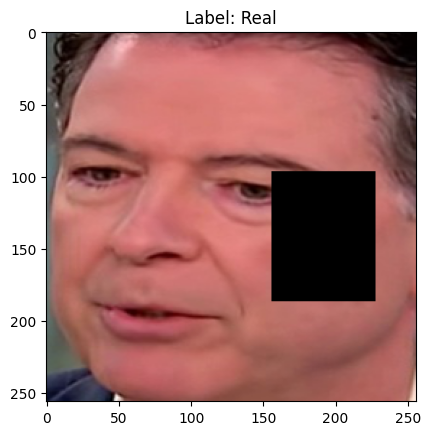

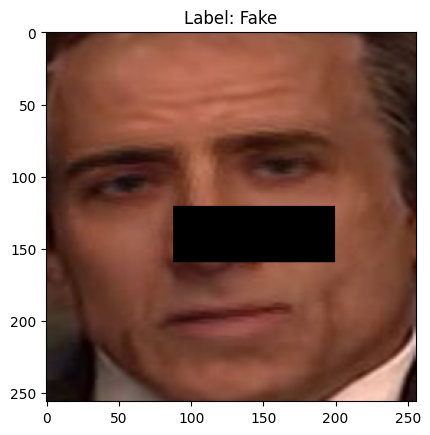

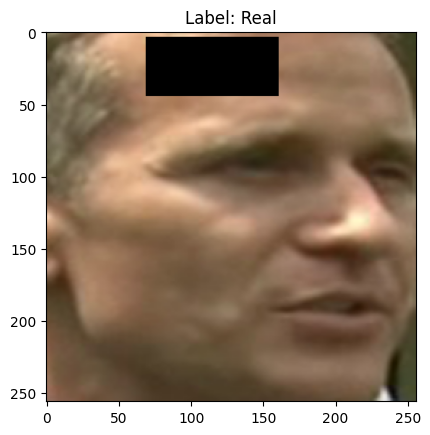

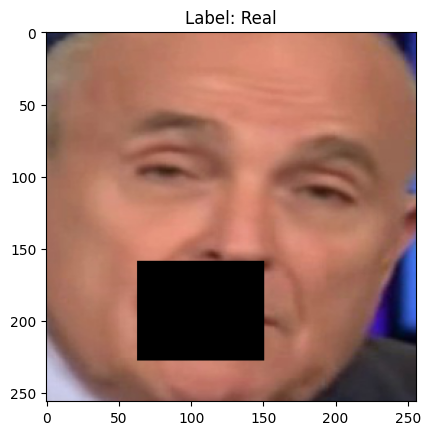

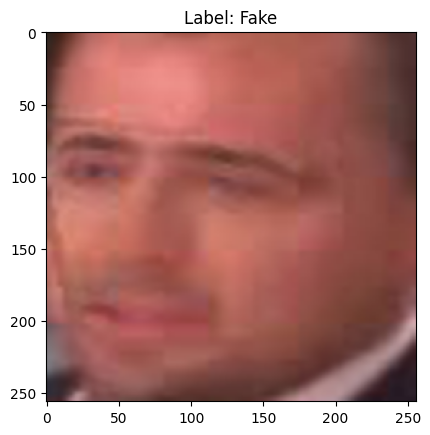

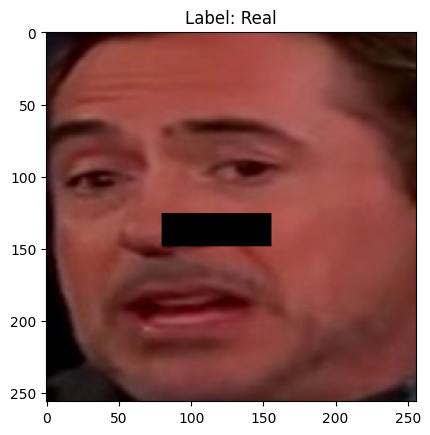

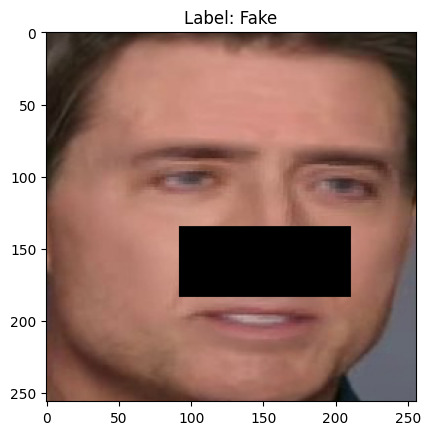

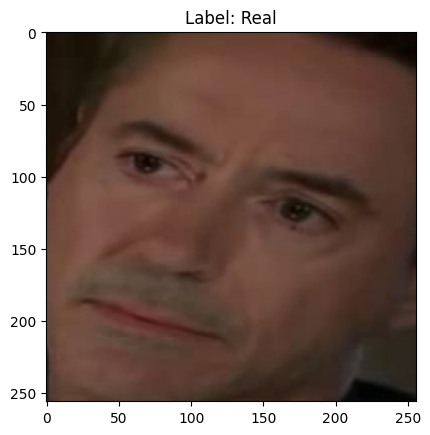

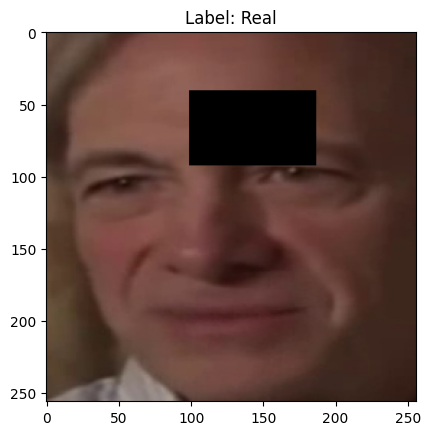

In [3]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
# Iterar sobre el DataLoader
i = 0
for patches, labels in dataloader:
    if i > 30:
        break
    patch = patches.squeeze(0)  # Elimina la dimensión del batch
    plt.imshow(patch.numpy().transpose(1, 2, 0))  # Muestra el parche
    plt.title(f'Label: {"Real" if labels.item() == 0 else "Fake"}')  # Muestra la etiqueta
    plt.show()
    i += 1


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader


In [6]:
from torch.utils.data import random_split

# Tamaño del conjunto de datos completo
total_size = len(dataset)

# Porcentajes de división
train_size = int(0.8 * total_size)
val_size = total_size - train_size

# Dividir el conjunto de datos
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


In [7]:
from torch.utils.data import DataLoader

# Parámetros del DataLoader
batch_size = 16

# DataLoader para el conjunto de entrenamiento
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# DataLoader para el conjunto de validación
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [8]:
def initialize_model(num_classes):
    # Cargar modelo ResNet-18 sin pesos preentrenados
    model = models.resnet18(pretrained=False)
    
    # Obtener el número de características de entrada de la última capa lineal
    num_ftrs = model.fc.in_features
    
    # Reemplazar la última capa lineal por una nueva que se ajuste al número de clases (2 en este caso)
    model.fc = nn.Linear(num_ftrs, num_classes)
    
    return model

# Inicializar el modelo
model = initialize_model(num_classes=2).to(device)


C:\Users\X571\anaconda3\envs\gpu_pytorch3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\X571\anaconda3\envs\gpu_pytorch3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [10]:
def adjust_learning_rate(optimizer, epoch):
    """Ajusta el learning rate del optimizador al nuevo valor si estamos en el epoch especificado."""
    if epoch == 7:  # Ajustar el lr en este epoch
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.0005
            
    #elif epoch == 10:  # Ajustar el lr en este epoch
        #for param_group in optimizer.param_groups:
            #param_group['lr'] = 0.0001
            #print("iuiuiuiu")



def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    # Listas para almacenar los resultados
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        adjust_learning_rate(optimizer, epoch+1)  # epoch+1 para que coincida con tu conteo
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Bucle de entrenamiento
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = running_corrects.double() / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        model.eval()
        val_loss = 0.0
        val_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs} Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

    return train_losses, val_losses, train_accs, val_accs
    
train_losses, val_losses, train_accs, val_accs=train_model(model, criterion, optimizer ,train_loader, val_loader, num_epochs=15)

Epoch 1/15 Train Loss: 0.9110 Acc: 0.5274 Val Loss: 0.7999 Acc: 0.5091
Epoch 2/15 Train Loss: 0.5765 Acc: 0.6768 Val Loss: 24.3535 Acc: 0.4667
Epoch 3/15 Train Loss: 0.4276 Acc: 0.8034 Val Loss: 0.3501 Acc: 0.8364
Epoch 4/15 Train Loss: 0.4214 Acc: 0.8079 Val Loss: 0.3216 Acc: 0.8242
Epoch 5/15 Train Loss: 0.3820 Acc: 0.8598 Val Loss: 0.3491 Acc: 0.8667
Epoch 6/15 Train Loss: 0.2705 Acc: 0.8780 Val Loss: 0.2118 Acc: 0.9273
Epoch 7/15 Train Loss: 0.2171 Acc: 0.9146 Val Loss: 0.1103 Acc: 0.9576
Epoch 8/15 Train Loss: 0.1909 Acc: 0.9192 Val Loss: 0.8603 Acc: 0.7333
Epoch 9/15 Train Loss: 0.1701 Acc: 0.9207 Val Loss: 0.1364 Acc: 0.9455
Epoch 10/15 Train Loss: 0.1556 Acc: 0.9405 Val Loss: 0.2891 Acc: 0.8545
Epoch 11/15 Train Loss: 0.1709 Acc: 0.9345 Val Loss: 0.1841 Acc: 0.9273
Epoch 12/15 Train Loss: 0.1685 Acc: 0.9299 Val Loss: 0.1601 Acc: 0.9455
Epoch 13/15 Train Loss: 0.1413 Acc: 0.9405 Val Loss: 0.0995 Acc: 0.9394
Epoch 14/15 Train Loss: 0.0922 Acc: 0.9543 Val Loss: 0.1285 Acc: 0.9515


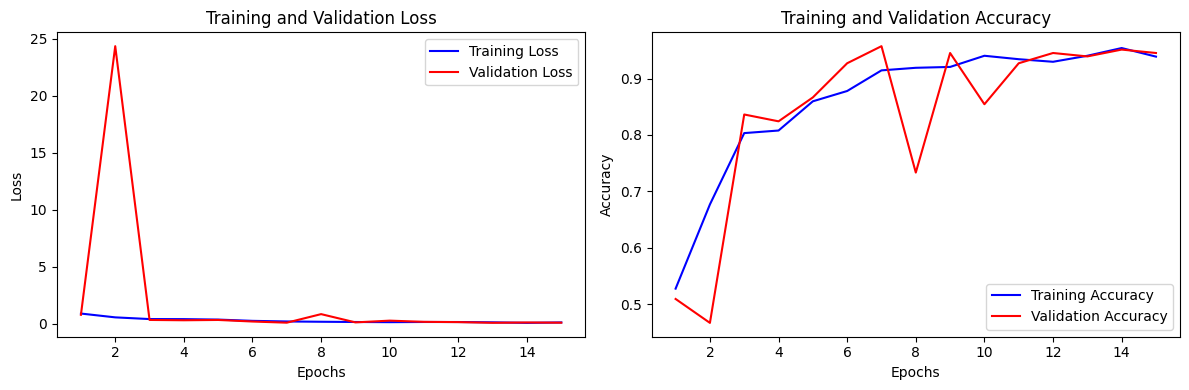

In [11]:
import numpy as np
def plot_results(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)

    # Convertir a arrays de NumPy después de asegurarse de que están en CPU si son tensores
    if isinstance(train_losses[0], torch.Tensor):
        train_losses_np = np.array([loss.item() for loss in train_losses])
    else:
        train_losses_np = np.array(train_losses)
    
    if isinstance(val_losses[0], torch.Tensor):
        val_losses_np = np.array([loss.item() for loss in val_losses])
    else:
        val_losses_np = np.array(val_losses)
    
    if isinstance(train_accs[0], torch.Tensor):
        train_accs_np = np.array([acc.item() for acc in train_accs])
    else:
        train_accs_np = np.array(train_accs)
    
    if isinstance(val_accs[0], torch.Tensor):
        val_accs_np = np.array([acc.item() for acc in val_accs])
    else:
        val_accs_np = np.array(val_accs)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses_np, 'b-', label='Training Loss')  # Líneas sólidas azules
    plt.plot(epochs, val_losses_np, 'r-', label='Validation Loss')  # Líneas sólidas rojas
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs_np, 'b-', label='Training Accuracy')  # Líneas sólidas azules
    plt.plot(epochs, val_accs_np, 'r-', label='Validation Accuracy')  # Líneas sólidas rojas
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
plot_results(train_losses, val_losses, train_accs, val_accs)


## TEST TASK 1

In [12]:
# Asumiendo que tienes una clase DeepfakePatchDataset
test_dataset = DeepfakeFaceDataset(root_dir='C:/Users/X571/Documents/VIT/Task_1/evaluation',transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # batch_size=1 para procesar cada imagen individualmente


In [13]:
import torch
import numpy as np

def evaluate_model(model, test_loader, device='cuda'):
    model.eval()  # Poner el modelo en modo de evaluación
    model.to(device)
    correct = 0
    total = 0

    with torch.no_grad():  # Desactivar el cálculo de gradientes
        for inputs, labels in test_loader:
            inputs = inputs.to(device)  # Asegurarse de enviar los datos al dispositivo correcto
            labels = labels.to(device)
            outputs = model(inputs)
            
            _, preds = torch.max(outputs, 1)  # Obtener las predicciones finales
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f'Accuracy on test set: {accuracy:.4f}')


# Llamar a la función para evaluar el modelo
evaluate_model(model, test_loader)


Accuracy on test set: 0.8651


## TASK 2

In [14]:
# Asumiendo que tienes una clase DeepfakePatchDataset
test_dataset = DeepfakeFaceDataset(root_dir='C:/Users/X571/Documents/VIT/Image-Classification-Using-Vision-transformer-main/Task_2_3/evaluation',transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # batch_size=1 para procesar cada imagen individualmente


In [15]:
def evaluate_model(model, test_loader, device='cuda'):
    model.eval()  # Poner el modelo en modo de evaluación
    model.to(device)
    correct = 0
    total = 0

    with torch.no_grad():  # Desactivar el cálculo de gradientes
        for inputs, labels in test_loader:
            inputs = inputs.to(device)  # Asegurarse de enviar los datos al dispositivo correcto
            labels = labels.to(device)
            outputs = model(inputs)
            
            _, preds = torch.max(outputs, 1)  # Obtener las predicciones finales
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f'Accuracy on test set: {accuracy:.4f}')


# Llamar a la función para evaluar el modelo
evaluate_model(model, test_loader)


Accuracy on test set: 0.6099
